## Principal Components Analysis

In this notebook, we implement and compare a variety of Principal Components Analysis (PCA) methods. We start with a general description of PCA.

### Outline

---

[Standard PCA](#Intro)

[Generate data](#Generate)

**PCA**

1. [PCA using SVD](#PCASVD)
2. [PCA using covariance method](#PCAcov)
3. [PCA using sklearn](#PCAsk)
4. [PCA using regression approach](#PCAreg)
5. [PCA extensions](#PCAextensions)


In [1]:
'''
Initialize notebook
'''

# Load dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
np.set_printoptions(suppress=True)
from ipywidgets import interact

# Figure aesthetics
cmap = sns.light_palette(color='electric blue', input='xkcd', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)
cs = ['#1F4251', '#2D986D', '#195BA7', '#7B9BE3', '#ECE9E9']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

# Magic commands
%config InlineBackend.figure_format = 'retina'

In [2]:
# Useful functions
def browse_heatmaps(X, X_approx_arr, E_approx_arr):
    '''Display rank r matrix approximations
    
    Parameters
    ----------
    X: np.array
      Data matrix
    X_approx_arr: np.array
      Array of X approximations
    E_approx_arr: np.array
      Error (X - X_approx)
    '''
    n = X_approx_arr.shape[0]
    def view_heatmap(r):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
        fig.suptitle(f'Rank {r+1} data reconstruction', fontsize=14, y=0.94)
        sns.heatmap(X, ax=axs[0], **hm_kwargs, vmin=-0.5, vmax=0.5)
        sns.heatmap(X_approx_arr[r], ax=axs[1], **hm_kwargs, vmin=-0.5, vmax=0.5)
        sns.heatmap(E_approx_arr[r], ax=axs[2], **hm_kwargs, vmin=-0.5, vmax=0.5)
        axs[0].set_title(r'$\mathbf{X}$')
        axs[1].set_title(r'$\hat{\mathbf{X}}$')
        axs[2].set_title(r'$\mathbf{E}$')
        plt.show()
    interact(view_heatmap, r=(0, n-1))

### Standard PCA <a id='Intro'></a>

PCA is a dimension reduction technique that aims to reduce the dimensionality of a given data matrix $\mathbf{X}$ whilst preserving as much information as possible. This is done by projecting each data point onto only the first few principal components to obtain lower-dimensional data. The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The $i^\text{th}$ principal component can be taken as a direction orthogonal to the first $i-1$ principal components that maximizes the variance of the projected data.

PCA can be formulated as the statistical interpretation of SVD. Given the data, it gives us a hierarchical coordinate system to represent the statistical variations: the directions are such that they capture the maximum amount of variance in he data. 

### Matrix norms

To quantify how much the reconstructed data $\mathbf{\hat{X}}$ differs from the actual data $\mathbf{X}$ we subtract the two and take the norm of the resulting matrix. The *norm* is a function that maps a matrix to a scalar number. It is a way to measure the size of a matrix.

There are a variety of norms out there that emphasize or suppress certain aspects. Here, we choose the Frobenius norm, which is the square root of the sum of the absolute squares of the individual elements,
\begin{align}
  \| X \|_F &= \sqrt{\sum_{i=1}^n \sum_{j=1}^p |x_{ij}|^2} = \sqrt{\text{trace}( \mathbf{X}^T \mathbf{X}})
\end{align}

Now we have a way to express the distance between two matrices, we can define the _loss_ and keep track of how the estimate improves when the rank increases.

### Generate data <a id='Generate'></a>

We illustrate the above using a random example. This is then used in the remainder of this notebook to compare different PCA techniques.

Note that the convention in Neuroscience is to put neurons `n` on the rows and timepoints `p` on the columns.

In [3]:
'''
Generate random data
'''
# Fix the seed for reproducibility
np.random.seed(42)

# Specify example dimensions
n = 30 # observations
p = 10 # features

# Generate example data
X_raw = np.random.rand(n, p)
X = X_raw - np.outer(np.ones(n), np.mean(X_raw, axis=0))

# Define loss function with the Frobenius norm
L = lambda E: np.sqrt(np.trace(E @ E.T))

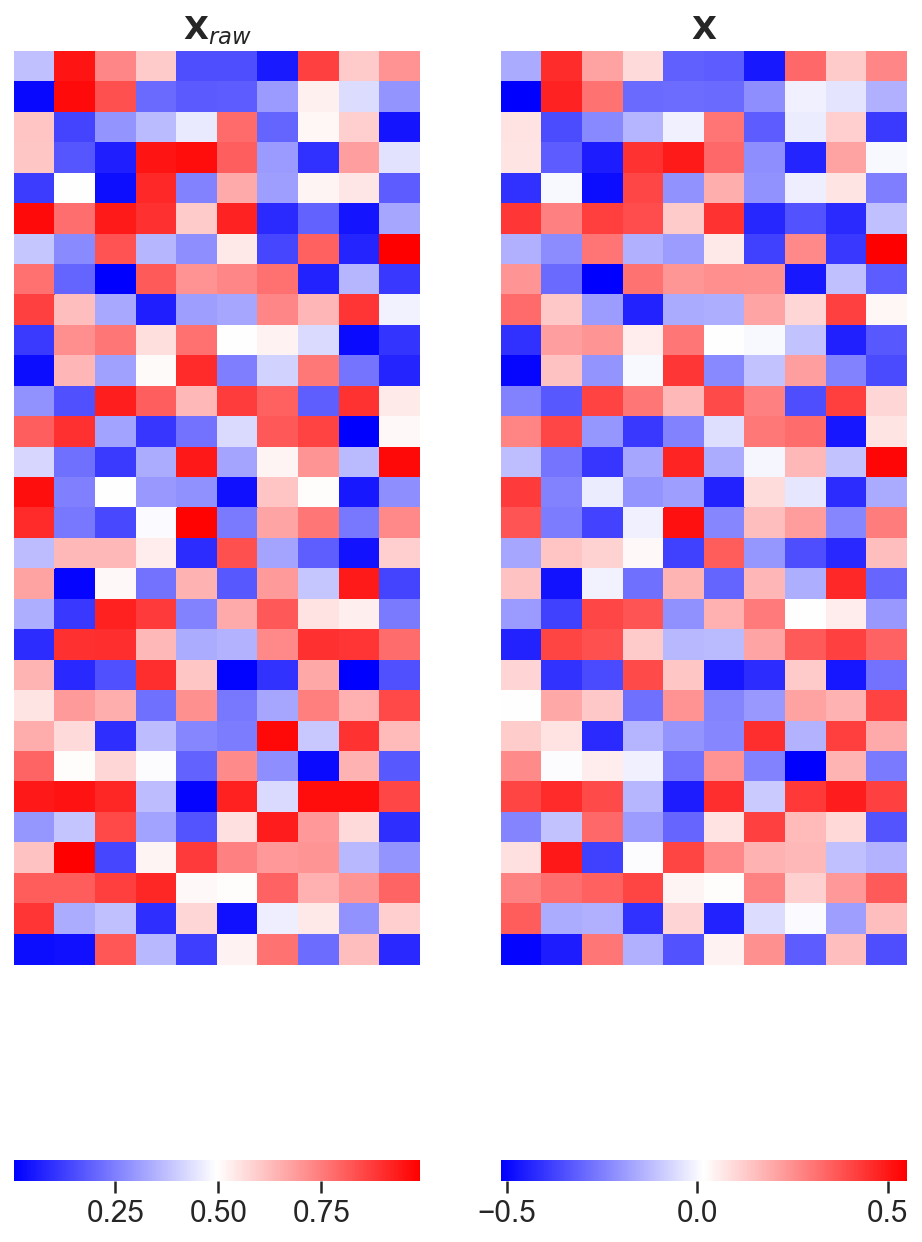

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 12))
hm_kwargs = {
  'xticklabels' : False,
  'yticklabels' : False,
  'cbar_kws' : {'orientation' : 'horizontal'},
  'cmap' : sns.color_palette('bwr', as_cmap=True)
}
sns.heatmap(X_raw, ax=axs[0], **hm_kwargs)
sns.heatmap(X, ax=axs[1], **hm_kwargs)
axs[0].set_title(r'$\mathbf{X}_{raw}$')
axs[1].set_title(r'$\mathbf{X}$');

### 1 PCA using SVD <a id='PCASVD'></a>

PCA can be computed trough the Singular Value Decomposition (SVD), which is closely related to eigendecomposition. In fact, SVD can be seen as a generalization of eigendecomposition. Any matrix can be decomposed using SVD, whereas eigendecomposition only applies to square matrices.

Applying SVD to a matrix $\mathbf{X}$ yields
\begin{align}
    \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\end{align}

---

#### SVD interpretation

> **TLDR.** We can think of $\mathbf{U}$ and $\mathbf{V}$ matrices as the eigenvectors of the variance-covariance matrix, which is given by $\mathbf{X}\mathbf{X}^T$ or $\mathbf{X}^{T} \mathbf{X}$. 

> Recall that eigendecomposition is not defined for non-square matrices. However, any matrix can be made square by multiplying it by its transpose, that is,  
\begin{align}
    \mathbf{X}^T \mathbf{X} &= 
\begin{bmatrix} 
- & & \mathbf{x}_1^T & &  -  \\
- & & \mathbf{x}_2^T & &  -  \\
  & & \vdots &               \\
\end{bmatrix}
\begin{bmatrix} 
\mid & \mid &  & \\
 \mathbf{x}_1 & \mathbf{x}_2 & \dots \\
\mid & \mid &  & \\
\end{bmatrix} \\
\text{we take the rows of } \mathbf{X}^T \times \text{ columns of } \mathbf{X} \\ 
&= \begin{bmatrix}
  \mathbf{x}_1^T \mathbf{x}_1 & \mathbf{x}_1^T \mathbf{x}_2 & \dots & \mathbf{x}_1^T \mathbf{x}_p \\
\mathbf{x}_2^T \mathbf{x}_1 & \mathbf{x}_2^T \mathbf{x}_2 &   \dots & \mathbf{x}_2^T \mathbf{x}_p \\
\vdots & \vdots &  & \vdots \\
\mathbf{x}_p^T \mathbf{x}_1 & \mathbf{x}_p^T \mathbf{x}_2 &   \dots & \mathbf{x}_p^T \mathbf{x}_p
\end{bmatrix}
\end{align}
will be square. 

> Notice that every entry in $\mathbf{X}^T \mathbf{X}$ is an inner product between two columns in the matrix $\mathbf{X}$:
\begin{align}
  x_i^T x_j = \langle x_i, x_j \rangle
\end{align}

[Neuro interpretation]()

> One way to compute the SVD of any rectangular matrix - often not used in practice, however - is
1. Compute the eigendecomposition of $\mathbf{X}^T\mathbf{X}$ to obtain $\Sigma$ and $\mathbf{V}$
2. Compute the eigendecomposition of $\mathbf{X}\mathbf{X}^T$ to obtain $\mathbf{U}$

> Here is why this can be done. 
\begin{align}
    \mathbf{X}^T \mathbf{X} &= (\mathbf{U} \mathbf{\Sigma} \mathbf{V}^T)^T \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \\
                            &= \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T  \\ 
                            &= \mathbf{V} \mathbf{\Sigma}^2 \mathbf{V}^T  \\
\end{align}

> So $\Sigma^2$ are the eigenvalues of the correlation matrix and the $\mathbf{V}'s$ are the respective eigenvectors. The right singular vectors $\mathbf{V}$ in the SVD are just the eigenvectors of the column-wise correlation matrix. Likewise, we can substitute the reverse $\mathbf{X} \mathbf{X}^T$ to get $\mathbf{U}$.

---


In [5]:
'''
Implement PCA using SVD
'''
# Apply SVD on the data
U, S, Vt = np.linalg.svd(X)
S_svd = np.diag(S)

In [6]:
U.shape, S_svd.shape, Vt.shape

((30, 30), (10, 10), (10, 10))

Now we construct the low rank approximations of the data using the first $r$ principal components.

We take the first $r$ columns of $\mathbf{U}$ times the first $r \times r$ block in $\Sigma$, times the first $r$ columns of $\mathbf{V}^T$. Using the slider it is clear that the error decreases as the rank increases.

In [9]:
X_svd_arr, E_svd_arr = [], []

for r in np.arange(1, 11, 1):
    # Reconstruct data using rank r columns
    X_svd = U[:, :r] @ S_svd[0:r, :r] @ Vt[:r, :]
    # Store 
    X_svd_arr.append(X_svd)
    E_svd_arr.append(X - X_svd)

X_svd_arr, E_svd_arr = np.array(X_svd_arr), np.array(E_svd_arr)

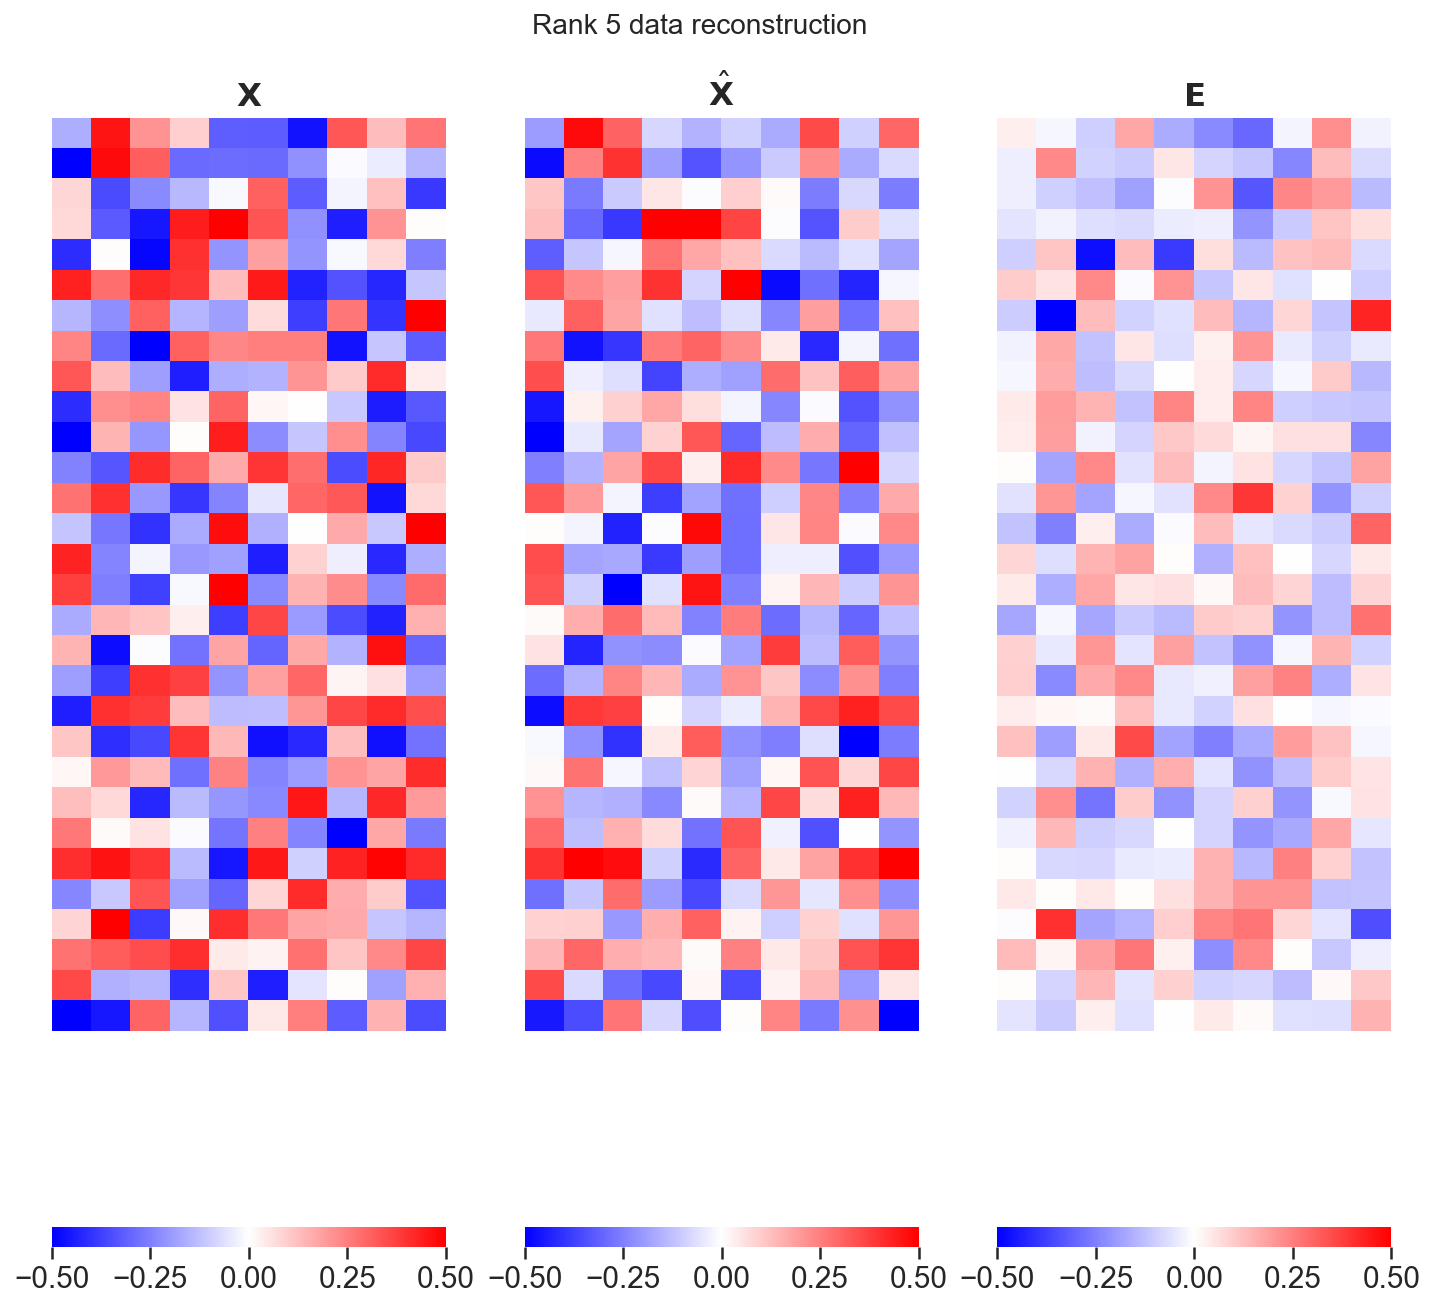

In [10]:
browse_heatmaps(X, X_svd_arr, E_svd_arr)

### 2 PCA using the covariance method <a id='PCAcov'></a>


Another way to get the principal components is from the covariance matrix. Our data matrix $\mathbf{X}$ has a mean of zero. 

All pairwise covariances are computed as follows

- If $\mathbf{X}$ is of the form (observations $\times$ features)
\begin{align}
    \mathbb{Cov} = \mathbf{X}^T \mathbf{X} \cdot \frac{1}{n-1} 
\end{align}
- If $\mathbf{X}$ is of the form (features $\times$ observations)
\begin{align}
    \mathbb{Cov} = \mathbf{X} \mathbf{X}^T \cdot \frac{1}{n-1} 
\end{align}
where $n$ is the number of obervations.

In [ ]:
Cov = X.T @ X / (n - 1)

In [ ]:
Cov.shape # (p x p) = (features x features)

(10, 10)

We take the eigendecomposition of the covariance matrix, which returns a matrix with the eigenvalues and the respective eigenvectors

In [ ]:
# Get the eigenvalues and right eigenvectors 
eigvals, eigvecs = np.linalg.eig(Cov)

The largest eigenvalues correspond to the eigenvectors that capture most of the variance in our data. Thus, if we sort the eigenvectors by the eigenvalues in descending order we get the order of most relevant principal components.

In [ ]:
# Get the indices of the eigenvalues sorted in descending order
idxsort = np.argsort(eigvals)[::-1]
# Sort the eigenvalues and eigenvectors based on this order
eigvals = eigvals[idxsort]
eigvecs = eigvecs[:, idxsort]

How well are the principal components able to estimate the true data matrix? 

- Lets take $\mathbf{c}$ as the top principal component
- The projection of each datapoint onto the top principal component is $\mathbf{w} = \mathbf{X c}$
- The vector $\mathbf{w}$ contains the “loadings” for each observation along this axis
- The best approximation of the data is the outer product of $\mathbf{w}$ and $\mathbf{c}$: $\mathbf{\hat{X}} = \mathbf{w} \mathbf{c}^T$

This can be generalised for $r$ PCs by 

\begin{align}
    \mathbf{\hat{X}} &= \mathbf{W} \mathbf{C}^T = \sum_{i=1}^r \mathbf{w}_r \mathbf{c}_r^T
\end{align}

- $\mathbf{C}$ - principal components
- $\mathbf{W}$ - loadings

In [ ]:
X_cov_arr, E_cov_arr = [], []

for r in np.arange(1, 11, 1): 
    # Take the first r eigenvectors that corresponds to the first r eigenvalues
    C = eigvecs[:, :r]

    # Get the projection of each datapoint onto these top r principal components
    W = X @ C
    
    # Reconstruction of the data X using the r first PCs
    X_approx = W @ C.T
  
    # Store
    X_cov_arr.append(X_approx) 
    E_cov_arr.append(X - X_approx)

X_cov_arr, E_cov_arr = np.array(X_cov_arr), np.array(E_cov_arr)

In [ ]:
W.shape

(30, 10)

In [ ]:
X_cov_arr.shape, E_cov_arr.shape

((10, 30, 10), (10, 30, 10))

Reconstructing the data with just one principal component does not seem enough. The error $\mathbf{E}$ is quite large.

Here we reconstruct the data with the first 3 PCs instead. Notice that the error $\mathbf{E}$ is close to zero for many elements of the matrix. This shows that we are able to approximate the data reasonably well with just the first 3 principal components.

Use the slider to see how the estimates improve as more PCs are used.

In [ ]:
browse_heatmaps(X, X_cov_arr, E_cov_arr)

interactive(children=(IntSlider(value=4, description='r', max=9), Output()), _dom_classes=('widget-interact',)…

### 3 PCA using Sklearn <a id='PCAsk'></a>

Sklearn essentially uses the SVD to compute the Principal Components. We want to compare the results obtained with Sklearn to the methods in **1** and **2**.

In [ ]:
from sklearn.decomposition import PCA

# Initialize the model, return all PCs
pca = PCA() 
# Fit model on the data X
pca.fit(X);

In [ ]:
pca.components_.T.shape 

(10, 10)

In [ ]:
# The principal components, make sure they are structured in the form (n_features, n_components)
C = pca.components_.T
# The singular values
S = np.diag(pca.singular_values_)

In [ ]:
X_skl_arr, E_skl_arr = [], []

for r in np.arange(1, 11, 1): 

  # Project each data point onto the first r columns
  W = X @ C[:, :r]
  
  # Reconstruct the data using with the first r columns
  X_skl = W @ C[:, :r].T

  # Store
  X_skl_arr.append(X_skl)
  E_skl_arr.append(X - X_skl)

X_skl_arr, E_skl_arr = np.array(X_skl_arr), np.array(E_skl_arr)

In [ ]:
browse_heatmaps(X, X_skl_arr, E_skl_arr)

interactive(children=(IntSlider(value=4, description='r', max=9), Output()), _dom_classes=('widget-interact',)…

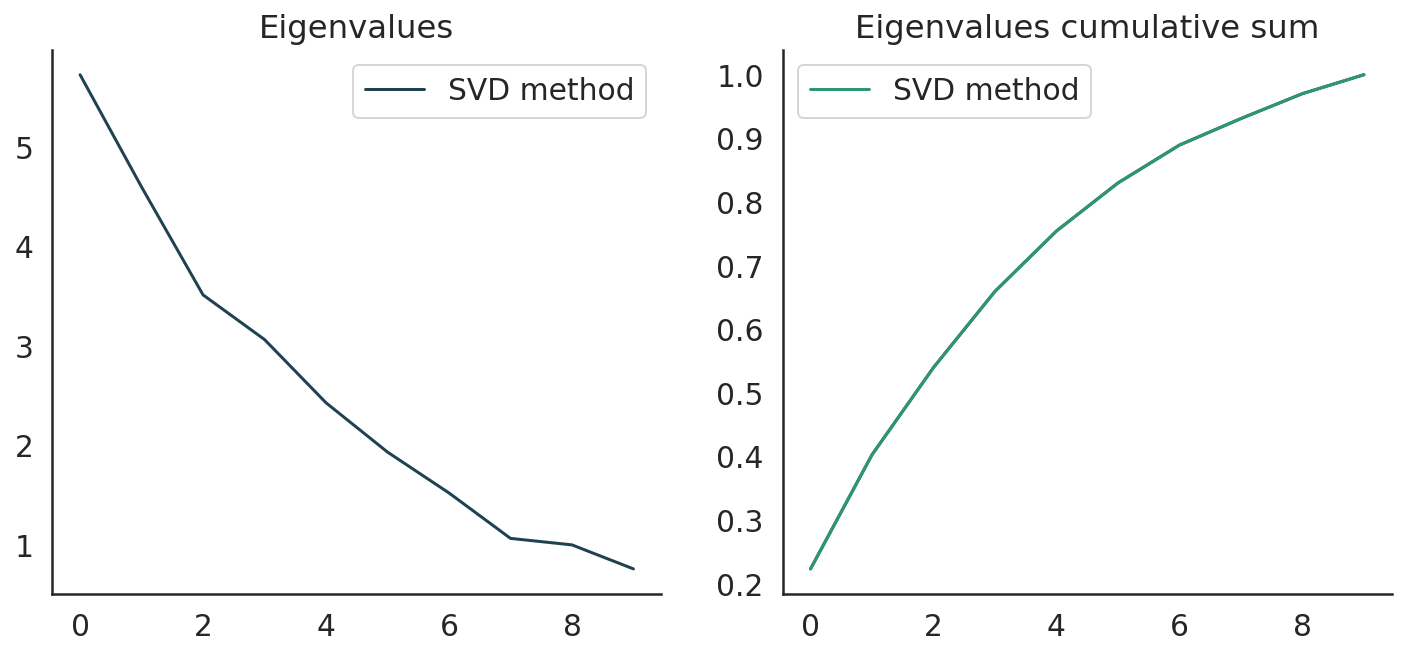

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].plot(np.diag(S_svd)**2, label='SVD method')
axs[0].set_title('Eigenvalues')
axs[1].plot(np.cumsum(np.diag(S)**2)/np.sum(np.diag(S)**2))
axs[1].plot(np.cumsum(np.diag(S_svd)**2)/np.sum(np.diag(S_svd)**2), label='SVD method')
axs[1].set_title('Eigenvalues cumulative sum')
axs[0].legend()
axs[1].legend()
sns.despine()

### 4 Sparse PCA using sklearn



In [ ]:
'''
Set parameters
'''

# L1 norm strength
a = 1

In [ ]:
from sklearn.decomposition import SparsePCA

# Initialize model 
spca = SparsePCA(n_components=X.shape[1], alpha=a, method='lars', verbose=1, tol=1e-8, normalize_components=True)
# Fit the model to the data
spca.fit(X)

[dict_learning] .+++.+++.+++.+++


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_sparse_pca.py:23: FutureWarning: 'normalize_components' has been deprecated in 0.22 and will be removed in 0.24. Remove the parameter from the  constructor.
  " constructor.", FutureWarning


SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
          n_components=10, n_jobs=None, normalize_components=True,
          random_state=None, ridge_alpha=0.01, tol=1e-08, verbose=1)

In [ ]:
# Get PCs
C_spca = spca.components_.T
C_spca.shape # components x features

(10, 10)

In [ ]:
X_spca_arr, E_spca_arr = [], []

for r in np.arange(1, 11, 1): 

  # Project each data point onto the first r columns
  W_spca = X @ C_spca[:, :r]
  
  # Reconstruct the data using with the first r columns
  X_spca = W_spca @ C_spca[:, :r].T

  # Store
  X_spca_arr.append(X_skl)
  E_spca_arr.append(X - X_skl)

X_spca_arr, E_spca_arr = np.array(X_spca_arr), np.array(E_spca_arr)

In [ ]:
browse_heatmaps(X, X_spca_arr, E_spca_arr)

interactive(children=(IntSlider(value=4, description='r', max=9), Output()), _dom_classes=('widget-interact',)…

In [ ]:
np.mean(transformer.components_ == 0) # most values in the components_ are zero (sparsity)

0.93

In [ ]:
spca.error_

[13.007748281295997,
 11.748878574533926,
 11.353129940019187,
 11.353129940019185]

### Compare loss and explained variances between 4 methods

Note that the loss is the same across the used methods.

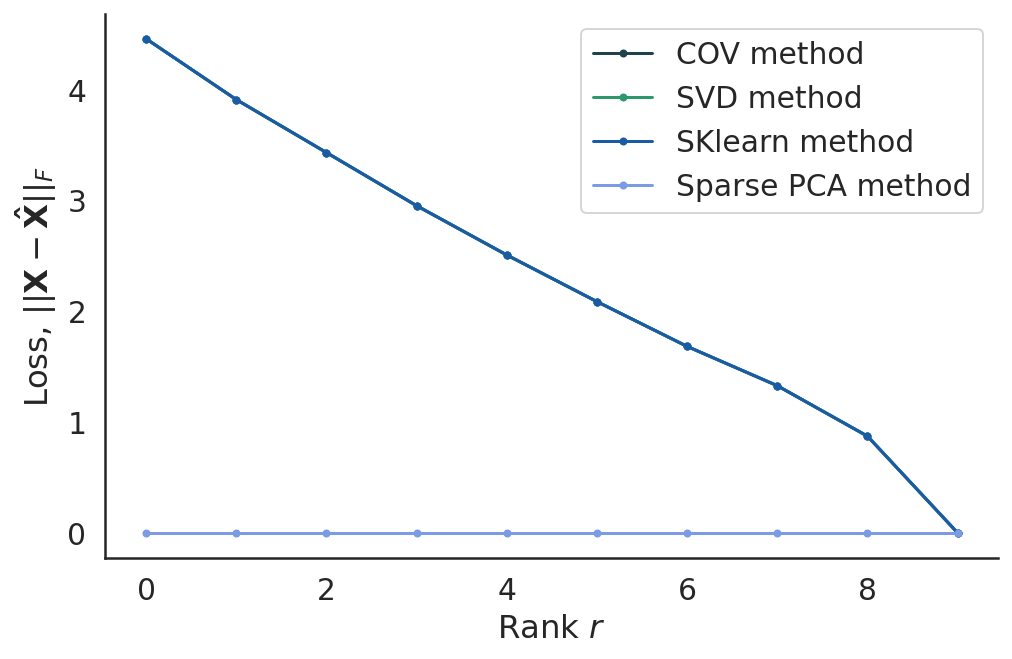

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot([L(E_cov_arr[e]) for e in range(len(E_cov_arr))], '.-', label='COV method')
ax.plot([L(E_svd_arr[e]) for e in range(len(E_svd_arr))], '.-', label='SVD method')
ax.plot([L(E_skl_arr[e]) for e in range(len(E_skl_arr))], '.-', label='SKlearn method')
ax.plot([L(E_spca_arr[e]) for e in range(len(E_spca_arr))], '.-', label='Sparse PCA method')
ax.set_xlabel(r'Rank $r$')
ax.set_ylabel(r'Loss, $|| \mathbf{X} - \mathbf{\hat{X}} ||_F$')
ax.legend()
sns.despine()

### 5 PCA using regression <a id='PCAreg'></a>


In [ ]:
x = 3 # true slope
a = np.arange(-2, 2, 0.25).reshape(-1, 1)
b = x * a + np.random.randn(*a.shape) # add some noise

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(a, x*a, label='True line')
ax.plot(a, b, 'x', label='Noisy data');

# Take SVD
U, S, Vt = np.linalg.svd(a, full_matrices=False)
xtilde = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T  @ b # Least squares fit

ax.plot(a, xtilde * a, '--', label='Regression line')
ax.set_xlabel(r'$\mathbf{a}$')
ax.set_ylabel(r'$\mathbf{b}$')
ax.legend()
sns.despine()

# Other method to compute regression
#xtilde = np.linalg.inv(a) @ b # using the pseudo inverse


The classical PCA problem is be formulated as follows. Let $\mathbf{X} \in \mathbb{R}^{n\times p}$ denote the given high dimensional data matrix with zero-mean columns for $n, p \in \mathbb{Z}$. Usually, we assume that $n \geq p$ or $n \gg p$, that is, $n$ is larger than or equal to $p$ or $n$ is much larger than $p$, respectively. 

$\mathbf{W} \in \mathbb{R}^{n \times p}$ is the matrix with the unit length $p$ principal components as columns. The associated loadings are the column vectors of the matrix $\mathbf{C} \in \mathbb{R}^{p \times p}$. The classical PCA objective function is then given by
\begin{align}
  \min_{\mathbf{W},\mathbf{C}} &\quad\left\|\mathbf{X} - \mathbf{W}\mathbf{C}^\top\right\|_{F}^{2} \\
  \text{s.t.} &\quad \mathbf{C}^\top\mathbf{C}=\mathbf{I}_p,
\end{align}
where $\|\cdot\|_{F}$ denotes the Frobenius norm and $\mathbf{I}_p$ denotes the $p \times p$ identity matrix. Note that we used that the Principal Components (PCs) are orthogonal in the above.

>_Side note:_ One does not need to require that the principal components are of unit length. In fact, the length need not even be restricted. Nevertheless, this is generally not recommended as it leads to numerical instability and general confusion.

It can easily be shown that the Singular Value Decomposition (SVD) of the matrix $\mathbf{X}$ can be used to find a global optimum for the constrained classical PCA. The SVD of the matrix $\mathbf{X}$ is given by 
\begin{align}
  \mathbf{X} = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^\top,
\end{align}
where $\mathbf{U} \in \mathbb{R}^{n \times n}$ and $\mathbf{V} \in \mathbb{R}^{p \times p}$ contain the unit length eigenvectors of $\mathbf{X}\mathbf{X}^{\top}$ and $\mathbf{X}^\top\mathbf{X}$ on the columns ranked by corresponding eigenvalue, respectively. Finally, the matrix $\boldsymbol{\Sigma}$ contains the $p$ possibly non-zero eigenvalues on the first $p$ diagonals followed by a $(n - p) \times p$ matrix of zeros, that is,
\begin{align}
  \boldsymbol{\Sigma} = \begin{bmatrix}
    \lambda_{1} & 0 & 0 & \ldots & 0 \\
    0 & \lambda_{2} & 0 & \ldots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \ldots & \lambda_{p} \\
    0 & 0 & 0 & \ldots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \vdots & 0
  \end{bmatrix},
\end{align}
where $\left\{\lambda_{i}\right\}_{i=1}^{p}$ are the $p$, possibly non-zero, eigenvalues. Note that we used that the remaining eigenvalues have to be zero as the matrices $\mathbf{X}\mathbf{X}^\top$ and $\mathbf{X}^\top\mathbf{X}$ have a rank that is smaller than or equal to $p$ (assuming $p \leq n)$. Then, a global optimum to the principal components problem is obtained by
\begin{align}
  \mathbf{W} = \mathbf{U}\boldsymbol{\Sigma} \text{ and } \mathbf{C} = \mathbf{V}.
\end{align}

Alternatively to the approach presented above, we can use regression to solve the PCA problem listed above. For the classical case, this approach does not make much sense. However, as we will see shortly, this approach allows us to introduce regularizations and additional restrictions to PCA.

The regression approach follows from the fact Frobenius norm is nothing more than the sum of squares. Therefore, the problem presented above is a regression problem when fixing either $\mathbf{W}$ or $\mathbf{C}$. It can be shown that alternating between fixing $\mathbf{W}$ and $\mathbf{C}$ and then optimizing over the other matrix can be used to solve the PCA problem. The pseudo-code for this algorithm is given below. Note that the last three steps ensure the PCs have unit length.

******
**Algorithm 1**:  PCA by alternating minimization

******
1. $\mathbf{W} \leftarrow $ intial value
2. $\mathbf{C} \leftarrow $ intial value
3. $\texttt{while}$ not converged:
4. $\qquad\mathbf{W} \leftarrow \underset{\mathbf{W}}{\text{argmin}} \left\|\mathbf{X} - \mathbf{W}\mathbf{C}^\top\right\|_F^2$
5. $\qquad\mathbf{C} \leftarrow \underset{\mathbf{C}}{\text{argmin}} \left\|\mathbf{X} - \mathbf{W}\mathbf{C}^\top\right\|_F^2$
6. $\mathbf{A} \leftarrow \mathbf{S}^\top\mathbf{S}$
7. $\mathbf{W} \leftarrow \mathbf{W}\mathbf{A}$
8. $\mathbf{S} \leftarrow \mathbf{S}\mathbf{A}^{-1}$
******


In [ ]:
# Specify maximum number of iterations and 
max_iter = 100
tol = 1e-4

# Define loss function
L = lambda X, W, C: np.power(np.linalg.norm(X - W @ C.T, 'fro'), 2)

loss = []
loss.append(100)

In [ ]:
W = np.random.rand((n, p))
S = np.random.rand((p, p))

for i in range()

  loss.append(L(X, W, C))
  
  if (loss[i] - loss[i-1] / loss[i-1])

In [ ]:
S = np.vstack((np.eye(p), np.zeros((n - p, p))))
W = np.random.rand(p, p)
loss = np.power(np.linalg.norm(X - S @ W.T, 'fro'), 2)
for i in range(max_iter):
    W = (np.linalg.inv(S.T @ S) @ S.T @ X).T
    S = (np.linalg.inv(W.T @ W) @ W.T @ X.T).T
    next_loss = np.power(np.linalg.norm(X - S @ W.T, 'fro'), 2)
    if ((next_loss - loss) / loss) < tol:
      break
    loss = next_loss
else: 
    warnings.warn('Algorithm did not converge')
A = S.T @ S
W_reg = W @ A
S_reg = S @ np.linalg.inv(A)

In [ ]:
print(f'Example - Regression\nS = {S_reg}\n\nW = {W_reg}')

### 6 PCA extensions 

#### 6.1 Regularisation

As a loose analogy, think of solution space of the matrices $\mathbf{W}$ and $\mathbf{C}$ as an energy landschape. The solution, that is, a particular parameterisation of $\mathbf{W}$ and $\mathbf{C}$ that the model will converge to is one with a very low loss or cost: a combination of $\mathbf{W}\mathbf{C}^\top = \hat{\mathbf{X}}$ that is close to $\mathbf{X}$.

The resulting solution is not unique. There are an infinite number of solutions that are roughly the same in terms of loss (rotation problem). However, we probably favor some solutions over others. For example, if I'd ask you to come up with a solution to the simple system
\begin{align}
  x + y = 10
\end{align}
you can list an infinite number of possible combinations for x and y that are all equally valid. $5, 5$ is a logical solution, or $2$ and $8$, but also $-1050,1060$ and $985, -975$ and so on..

The point is that we favor simple solutions (think about Occams razor), solutions that are close to zero. These are more *interpretable*. So we want to nudge our model a bit, guide it towards the simpler solutions. This is done by adding a regularization term. We include penalty term for solutions for $\mathbf{W}, \mathbf{C}$ that are far away from zero. Think of it as adding a layer on top of the energy landscape. Our resulting solutions may be a little bit less accurate, but that's ok. We are happy to trade some accuracy for interpretability.



#### 6.2 Weighted PCA

Some electrodes cover more neurons than others. In our electrodes, the variance between number of neurons covered per electrode is quite large.

One thing that can be done is to reweight the data $\mathbf{X}$ based on the amount of neurons on that electrode. 

### 6.3 Regularization for distances